In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from gc import collect
import wordcloud as wc
import sys, json, calendar
import matplotlib.pyplot as plt
from collections import Counter
from operator import itemgetter
from pandas.tools.plotting import table

In [2]:
plt.style.use("seaborn-dark-palette")
plt.rcParams["axes.titlesize"] = 16.
plt.rcParams["axes.labelsize"] = 16.
plt.rcParams["xtick.labelsize"] = 14.
plt.rcParams["ytick.labelsize"] = 14.
plt.rcParams["legend.fontsize"] = 11.
plt.rcParams["figure.frameon"] = False
plt.rcParams["figure.figsize"] = [15, 8]
plt.rcParams["font.family"] = "serif"

In [4]:
def aug_df(df):
    df.loc[:, "status_published"] = pd.DatetimeIndex(df.status_published.values)
    df.loc[:, "status_type"] = df.status_type.str.title()
    df.loc[:, "Month"] = df.status_published.dt.month
    df.loc[:, "Year"] = df.status_published.dt.year.astype(str)
    df.loc[:, "Day"] = df.status_published.dt.day
    df.loc[:, "Hour"] = df.status_published.dt.hour

In [6]:
harman = pd.read_csv("competitor analysis/HarmanInt_facebook_statuses.csv")
ameagle = pd.read_csv("competitor analysis/americaneaglecom_facebook_statuses.csv")
mutmob = pd.read_csv("competitor analysis/mutualmobile_facebook_statuses.csv")
solmob = pd.read_csv("competitor analysis/solsticemobile_facebook_statuses.csv")
softweb = pd.read_csv("competitor analysis/SoftwebSolutionsInc_facebook_statuses.csv")
aug_df(harman); aug_df(ameagle); aug_df(mutmob); aug_df(solmob); aug_df(softweb)
harman.drop(1427, inplace = True)
joined = lambda: (x for x in (softweb, harman, ameagle, mutmob, solmob))
index = ["Softweb Solutions", "Harman Intl.", "American Eagle", "Mutual Mobile", "Solstice Mobile"]

In [7]:
harman[harman.status_message.fillna("").str.contains("via")].status_message

81      It turns out people are ready for driverless c...
128     With connected vehicles growing in popularity,...
129     We’re thrilled that HARMAN’s innovative infota...
132     HARMAN is leading the technology charge that’s...
166     We’re likely to see computers moving from our ...
181     The rise of in-car connected services, is lead...
198     What's driving the connected car? As customers...
206     There’s a shift already taking place in the au...
211     A wide range on new technologies are available...
212     Smart cars of the future will have the ability...
216     A great turn out at the #MBMHonors last night,...
217     Imagine what our cars will be like in the near...
219     The #connectedcar will be a bigger part of our...
238     HARMAN is working to develop cloud services fo...
245     Today’s vehicles are increasingly becoming the...
277     Olivia Sterns stopped by the Harman booth yest...
288     Before we usher in a new year, here is a look ...
437     Harman

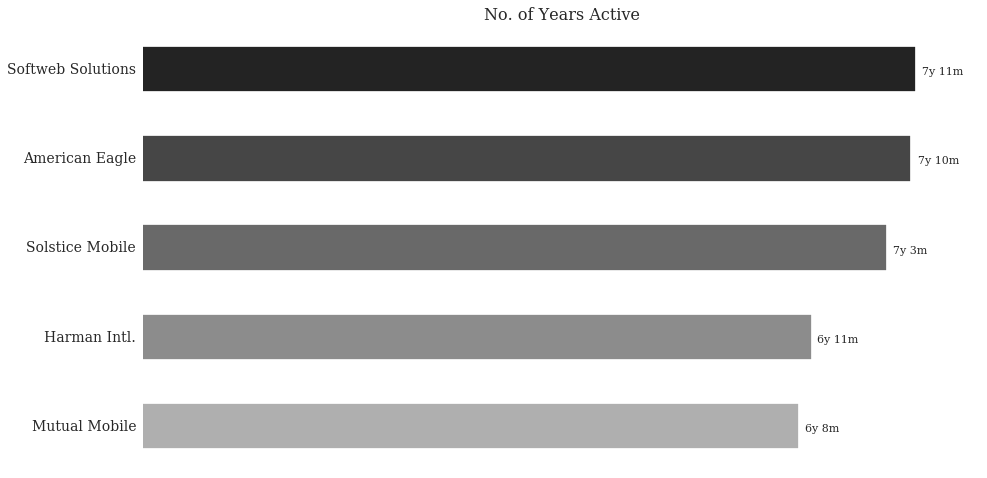

In [8]:
df = pd.DataFrame([max(x.status_published) - min(x.status_published)
                   for x in joined()], index = index
                 ).sort_values(0).rename(columns = {0: "time"})
df.loc[:, "years"] = df.time.dt.days / 365.25
ax = df.plot.barh(legend = False, title = "No. of Years Active", aa = True)
ax.set(frame_on = False, xticklabels = "")
for i, p in enumerate(ax.patches):
    t = df.ix[i].time.days
    p.set_color(map(plt.get_cmap("gray"), range(256))[::35][:6][::-1][i])
    ax.annotate('%dy %dm' % (t / 365, (t % 365) / 12),
                (p.get_y() + .19, p.get_width() * 1.01)[::-1],
                fontsize = 11.)

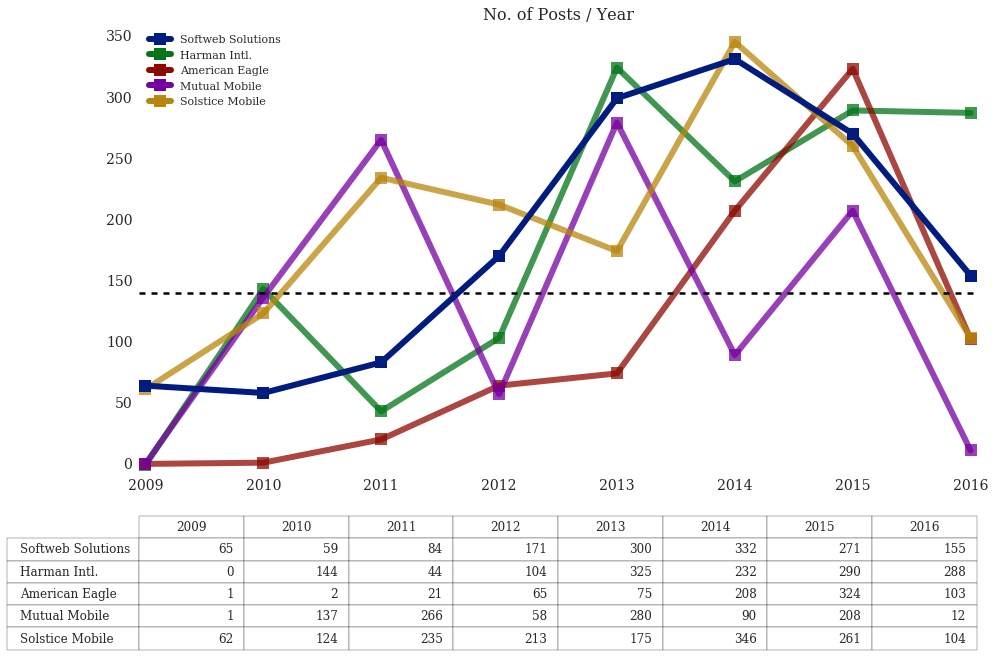

In [9]:
colors = colors#eval(plt.style.library["seaborn-dark-palette"].__repr__()[47:-3])#map(plt.get_cmap("Dark2"), range(256))[::35][:6][::-1]
df = pd.concat([df[["Year", "status_id"]].groupby("Year").count() for df in joined()], axis = 1).fillna(0).astype(int)
df.columns = index
ax = df.plot(ms = 12., marker = "s", lw = 6., title = "No. of Posts / Year", grid = False, color = colors)
table(ax = ax, data = df.T, loc = "bottom", bbox = [0., -0.4, 1., 0.3])
_ = ax.legend(index, loc = 0), [ax.lines[i].set(alpha = .75 if i > 0 else 1., zorder = 6 if i == 0 else 0) for i in range(len(index))],\
ax.set(xlim = (-.05, 7.05), ylim = (-5, 360), xticklabels = range(2008, 2017), frame_on = False),\
[x.set_color(colors[i]) for (i, x) in enumerate(ax.lines)], ax.plot(ax.get_xlim(), [df.stack().median()] * 2, "k--", lw = 2.5)
#ax.plot(range(8), df.mean(axis = 1), "b", lw = 25., alpha = .3)

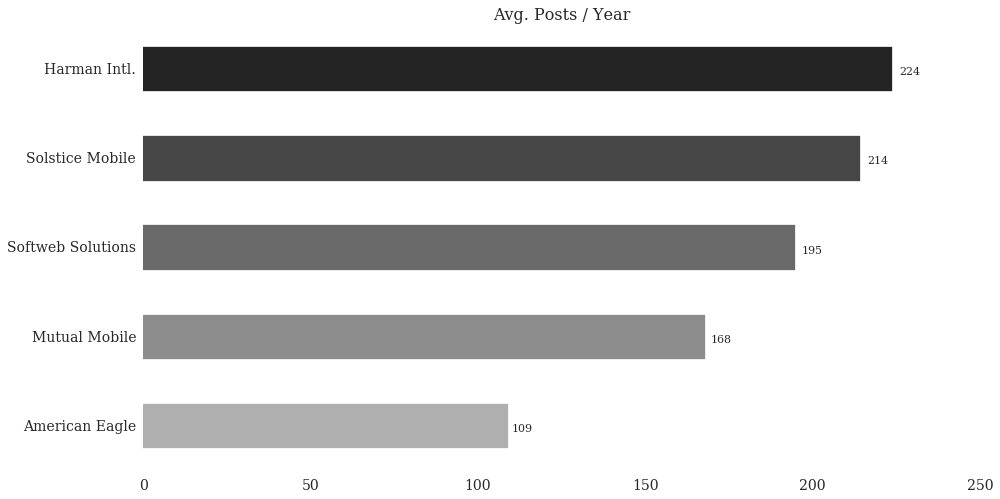

In [12]:
df = pd.DataFrame([len(x) for x in joined()], index = index).merge(
pd.DataFrame([(max(x.status_published) - min(x.status_published)).days / 365.
              for x in joined()], index = index), left_index = True,
right_index = True).copy(deep = True)
df = (df["0_x"] / df["0_y"]).sort_values(0)
ax = df.plot.barh(legend = False, title = "Avg. Posts / Year")
ax.set_frame_on(False)
for i, p in enumerate(ax.patches):
    ax.annotate('%d' % round(df.ix[i]), (p.get_y() + .19, p.get_width() * 1.01)[::-1], fontsize = 11.)
    p.set_color(map(plt.get_cmap("gray"), range(256))[::35][:6][::-1][i])

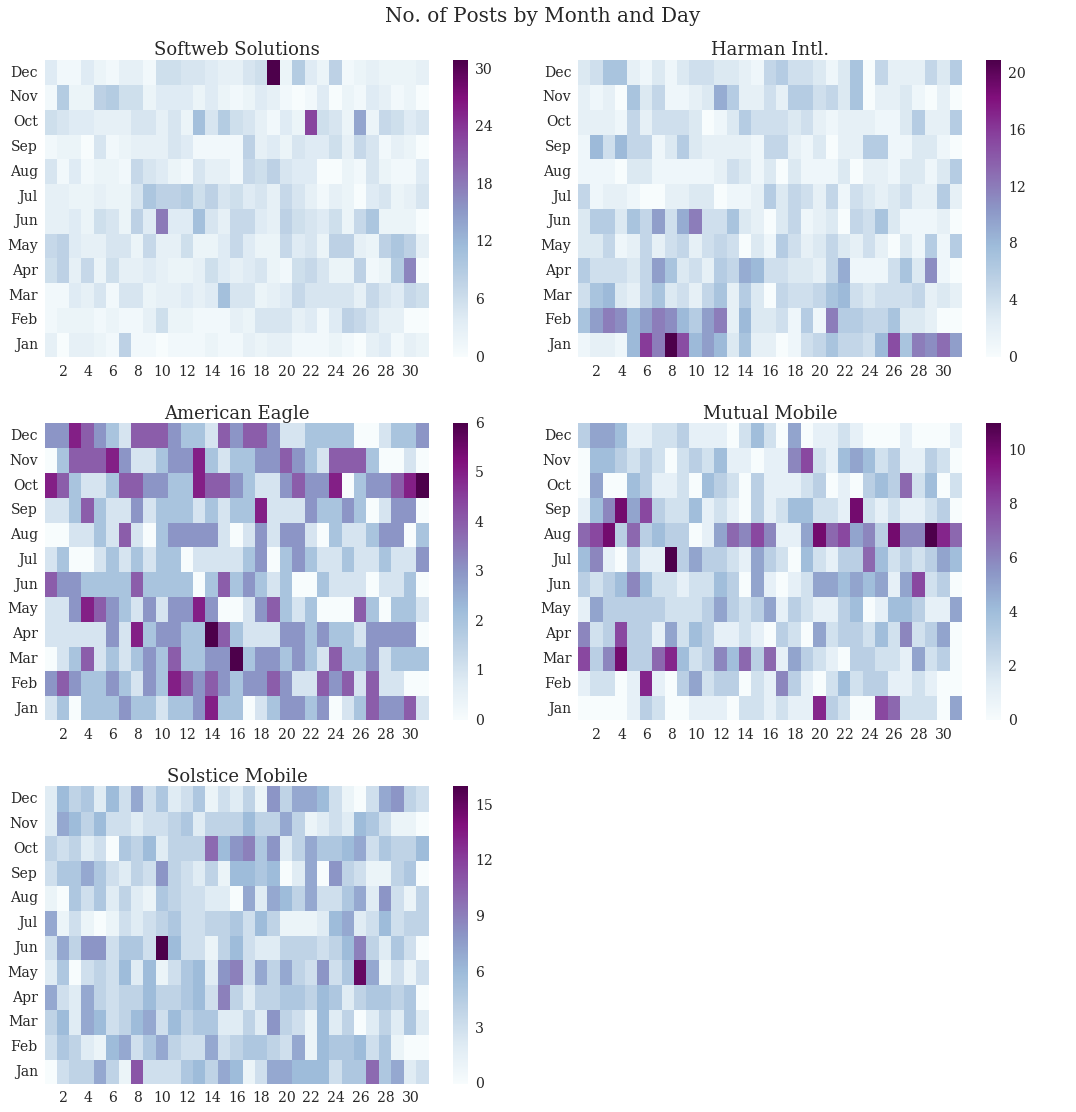

In [13]:
f, axes = plt.subplots(3, 2, figsize = (15, 15))
f.tight_layout(h_pad = 3)
for i, df in enumerate(joined()):
    tempdf = df.pivot_table("num_likes", "Month", "Day", aggfunc = len, fill_value = 0).sort_index(ascending = False).copy(deep = True)
    for x in [x for x in range(1, 32) if x not in tempdf.columns]: tempdf.loc[:, x] = 0
    ax = axes[i / 2][i % 2]
    _ = sns.heatmap(tempdf[range(1, 32)], ax = ax, cmap = "BuPu"),\
    ax.set_yticklabels([calendar.month_abbr[x] for x in tempdf.index[::-1]], rotation = 0),\
    ax.set_xticklabels(map(lambda x: x.get_text(), ax.get_xticklabels()), rotation = 0),\
    [x.set_visible(False) for x in ax.get_xticklabels()[::2]], ax.set_title(index[i], fontdict = dict(fontsize = 18.)),\
    ax.set(xlabel = "", ylabel = "")
_ = axes[-1, -1].axis("off"), f.suptitle("No. of Posts by Month and Day", fontsize = 20., y = 1.03), collect()

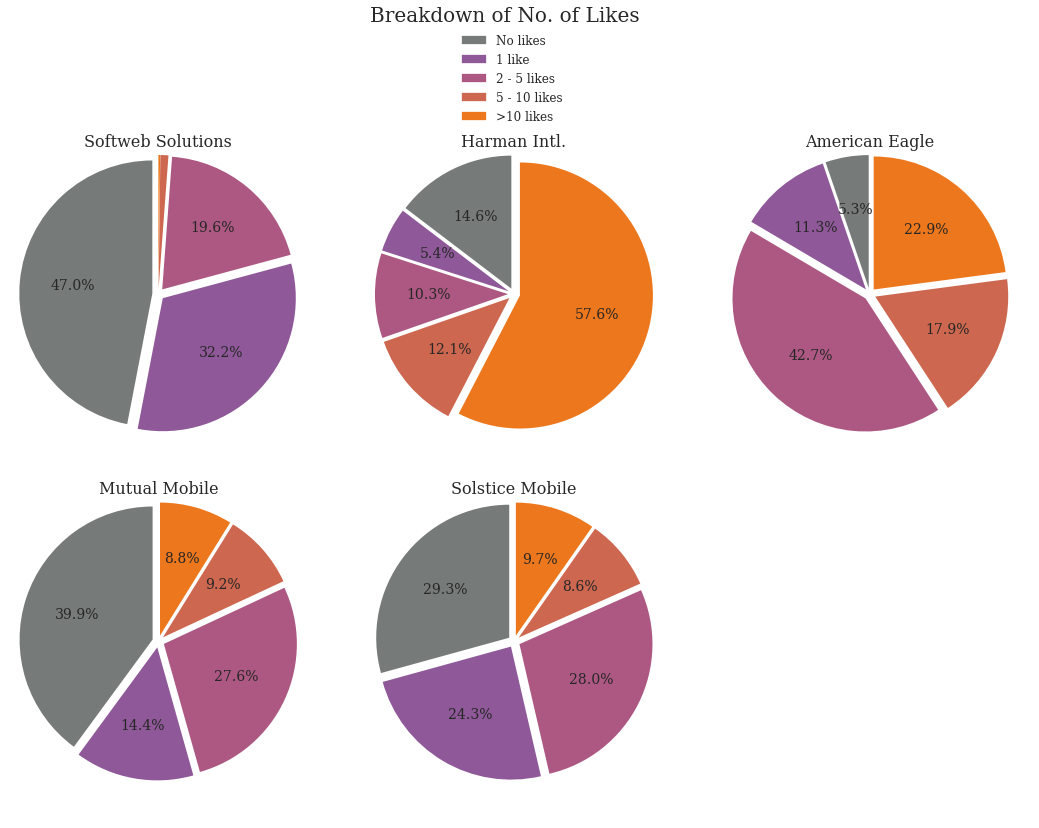

In [15]:
f, axes = plt.subplots(2, 3, figsize = (15, 10))
f.tight_layout(h_pad = .05)
colors = plt.cm.Set1(np.arange(15) / 25.)[-7:-2]
for i, df in enumerate(joined()):
    c = Counter(pd.cut(df.num_likes, [-1, 0, 1, 5, 10, 10000]))
    ax = axes[i / 3][i % 3]
    _ = ax.pie(itemgetter('(-1, 0]', '(0, 1]', '(1, 5]', '(5, 10]', '(10, 10000]')(c), colors = colors, explode = [.05] * 5, radius = 1.1,
               autopct = lambda x: "%.1f%%" % x if x > 1 else "", textprops = {"fontsize": 14.}, startangle = 90, wedgeprops = {"lw": 0.}),
    ax.set_title(index[i]), ax.title.set_position((.5, .97)), ax.set_aspect(1), collect()
_ = axes[-1, -1].axis("off"), f.suptitle("Breakdown of No. of Likes", fontsize = 20., y = 1.15),\
f.legend([plt.matplotlib.patches.Patch(x, x) for x in colors], ["No likes", "1 like", "2 - 5 likes", "5 - 10 likes", ">10 likes"], (0.44, 0.845), fontsize = 12.)

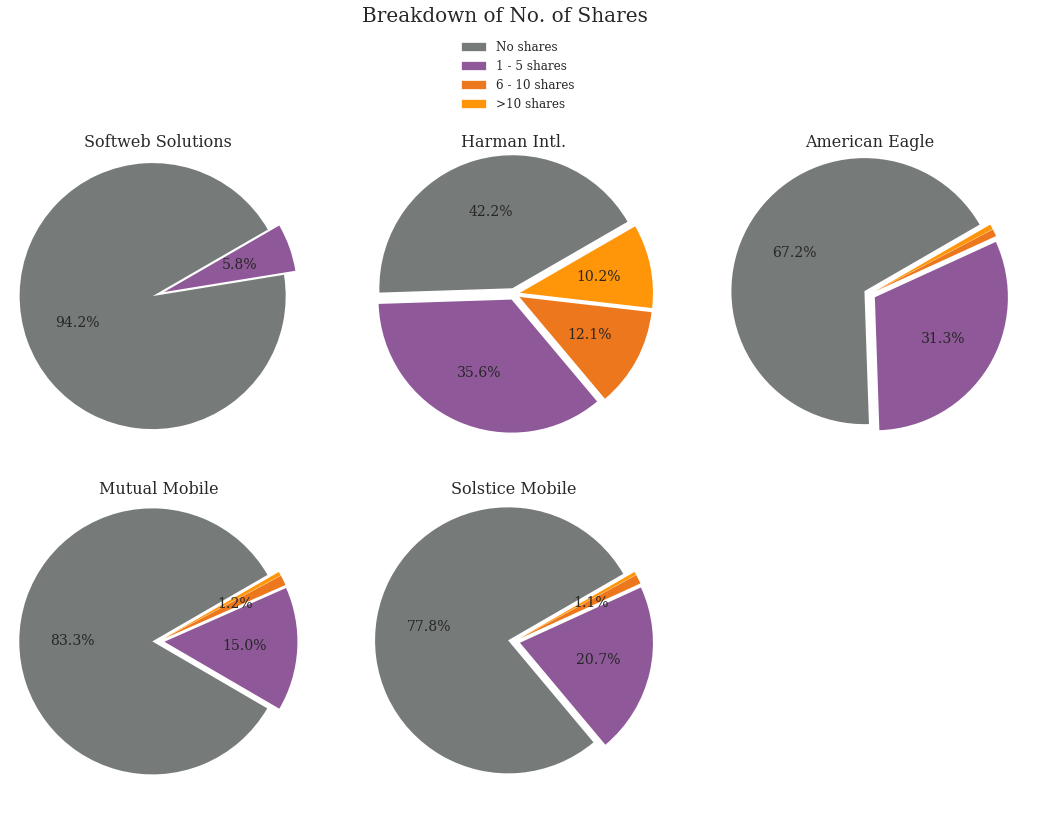

In [16]:
f, axes = plt.subplots(2, 3, figsize = (15, 10))
f.tight_layout(h_pad = .05)
colors = plt.cm.Set1(np.arange(15) / 25.)[[-7, -6, -3, -2]]
for i, df in enumerate(joined()):
    c = Counter(pd.cut(df.num_shares, [-1, 0, 5, 10, 10000]))
    ax = axes[i / 3][i % 3]
    _ = ax.pie(itemgetter('(-1, 0]', '(0, 5]', '(5, 10]', '(10, 10000]')(c), colors = colors, radius = 1.1,
               autopct = lambda x: '%.1f%%' % x if x > 1 else "", explode = [.05] * 4,
               textprops = {"fontsize": 14.}, startangle = 30, wedgeprops = {"lw": 0.}),
    ax.set_title(index[i]), ax.title.set_position((.5, .97)), ax.set_aspect(1), collect()
_ = axes[-1, -1].axis("off"), f.suptitle("Breakdown of No. of Shares", fontsize = 20., y = 1.15),\
f.legend([plt.matplotlib.patches.Patch(x, x) for x in colors], ["No shares", "1 - 5 shares", "6 - 10 shares", ">10 shares"], (0.44, 0.86), fontsize = 12.)

In [18]:
t = [t for t in mutmob.status_message.fillna("").values if any(["femin" in t, "gender" in t, "sexi" in t, "girl" in t,
                                               "woman" in t, "sexu" in t, "women" in t, "objecti" in t, "diver" in t,
                                               "lgbt" in t, "gay" in t, "lesbi" in t, "homo" in t, "equality" in t, "femal" in t])]

In [19]:
t = [t for t in harman.status_message.fillna("").values if any(["softweb" in t])]

In [20]:
def color_func(*args, **kwargs):
    return 'hsl(30, %d%%, %d%%)' % (np.random.randint(0, 80), min(165 - kwargs["font_size"], 25) * 2)

In [21]:
print softweb[softweb.status_message.fillna("").str.lower().str.contains("things")]["Year"].value_counts()

2015    19
2016    14
2014     9
2012     1
2013     1
Name: Year, dtype: int64


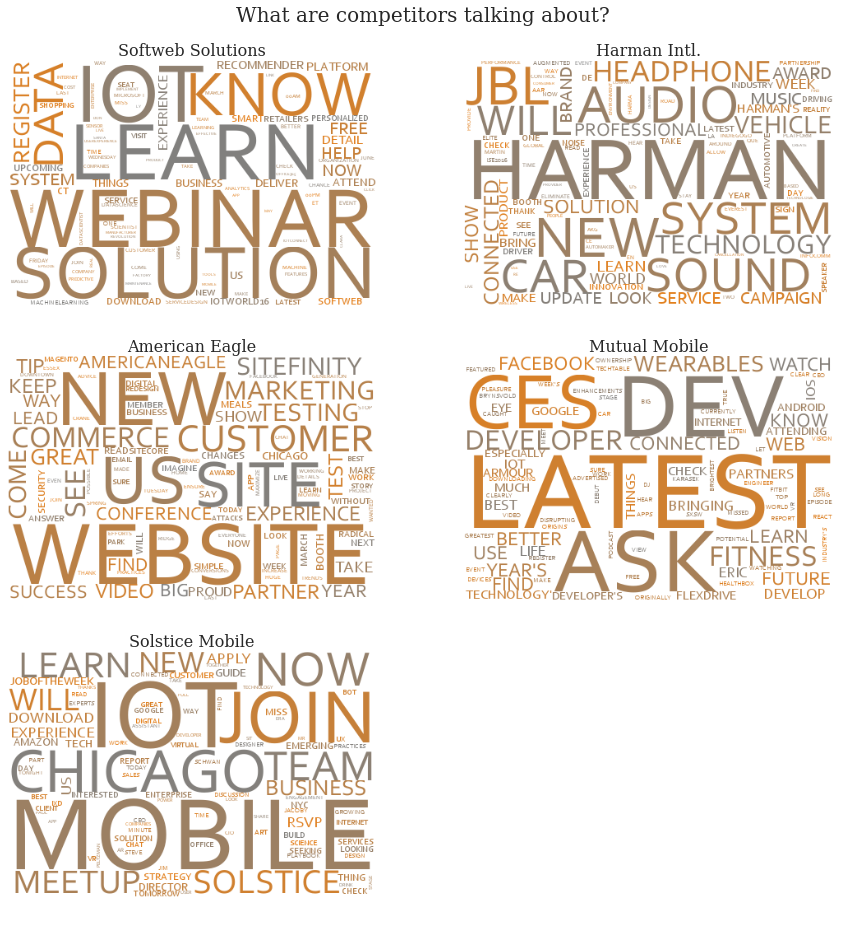

In [22]:
f, axes = plt.subplots(3, 2, figsize = (15, 15))
for (i, df) in enumerate(joined()):
    ax = axes[i / 2][i % 2]
    w = wc.WordCloud(width = 450, height = 300, background_color = "white", color_func = color_func, relative_scaling = .5, max_words = 100,
                    font_path = "C:\Windows\Fonts\corbel.ttf")
    text = ' '.join([x[:x.rfind("http")].upper() for x in df[df.Year == "2016"].status_message.fillna("").values])
    #text = ' '.join(mutmob.status_message.fillna("").values)
    w.generate_from_text(text)
    _ = ax.imshow(w), ax.grid(False), ax.set(xticklabels = "", yticklabels = "", title = index[i])
_ = axes[-1][-1].axis("off"), f.suptitle("What are competitors talking about?", fontsize = 20., y = .95, x = .515)